# Assignment 2: Bayesian Robots!
Algorithms such as SVMs and Gradient Boosting can have many hyperparameters. Tuning them manually is tedious and doing a grid search or random search can take too long and is not very principled. Indeed, a human machine learning expert would be able to learn from how well previous hyperparameter configurations worked to predict which configurations may work better. In this assignment, we will implement and use _Bayesian optimization_ to optimize our models in a more intelligent way. We will try this on one classification and one regression dataset: 

### Robot Navigation
The [Wall robot navigation](https://www.openml.org/d/1497) contains training data for a robot equiped with ultrasound sensors. Based on 24 sensor readings, the robot has to figure out how to move though an office space without hitting walls or other obstacles. The possible actions (classes) are 'Move-Forward', 'Slight-Right-Turn', 'Sharp-Right-Turn', and 'Slight-Left-Turn'. Since some of the sensors may break, we need a fast way to re-optimize the model so that it will keep working well. We will use Bayesian optimization for this.

You should optimize the following models (for simplicity, we will limit the assignment to 2 hyperparameters per model):  
* Support vector machine, with hyperparameters $C \in [10^{-12},10^{12}]$, $\gamma \in [10^{-12},10^{12}]$ (both log scale), and an RBF kernel.
* Gradient Boosting, with hyperparameters `learning_rate` $\in [10^{-4},10^{-1}]$ (log scale), `max_depth` $\in [1,5]$, and `n_estimators` fixed at least 1000 (you can increase this if your computing resources allow).

In [1]:
# General imports
%matplotlib inline
import openml as oml

# Download Wall Robot Navigation data from OpenML.
robotnav = oml.datasets.get_dataset(1497)
X, y, cats, attrs = robotnav.get_data(dataset_format='array',
    target=robotnav.default_target_attribute)
labels = ['Move-Forward','Slight-Right-Turn','Sharp-Right-Turn','Slight-Left-Turn']

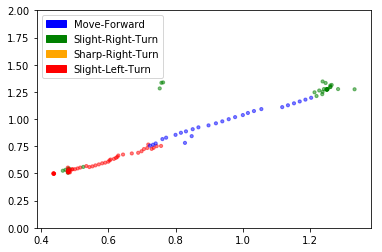

In [2]:
## Visualization of correct predictions based on the first 2 sensor readings
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors

cmap = colors.ListedColormap(['blue', 'green', 'orange', 'red'])
legend_handles = list()
for i in range(4):
    legend_handles.append(mpatches.Patch(color=cmap(i), label=labels[i]))
plt.legend(handles=legend_handles, loc='upper left')

n = 120 # First 120 points
plt.scatter(X[:,0][0:n], X[:,1][0:n], c=y[0:n], cmap=cmap, alpha=0.5, s=10)
plt.ylim(0,2);

### Robot arm
Our robot also has an arm consisting of 8 'links'. The [Kinematics 8NM](https://www.openml.org/d/189) dataset represents the forward dynamics of an 8-link all-revolute robot arm. The goal is to predict the distance of the end-effector from a target, given the twist angles (theta's) of the 8 links as features. Here, we also would like fast re-optimization when the robot is placed in a different environment.

You should optimize the following models (again, we will limit the assignment to 2 hyperparameters per model):  
* Gradient Boosting regressor, with hyperparameters `learning_rate` $\in [10^{-4},10^{-1}]$ (log scale), `max_depth` $\in [1,5]$, and `n_estimators` fixed at least 1000 (you can increase this if your computing resources allow).
* ElasticNet, with hyperparameters $\alpha \in [10^{-12},10^{12}]$ (log scale), and `l1_ratio` $\in [0,1]$. ElasticNet is a generalized linear model that use a loss function that is a mix of L1 and L2 loss. `l1_ratio` defines the weight of the L1 loss component. For `l1_ratio=0` the model behaves like ridge regression.

For the Gradient Boosting algorithm, you can choose between the scikit-learn and the XGBoost implementation. If you use the latter, you can use the [scikit-learn wrapper](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn).

In [3]:
# Download Wall Robot Navigation data from OpenML.
robotarm = oml.datasets.get_dataset(189)
Xr, yr, catsr, attrsr = robotarm.get_data(dataset_format='dataframe',
    target=robotarm.default_target_attribute)

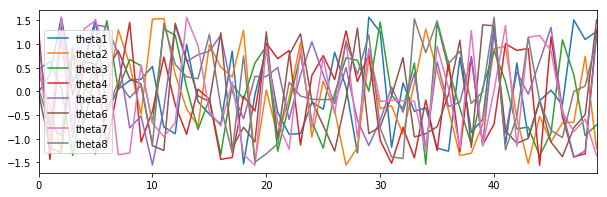

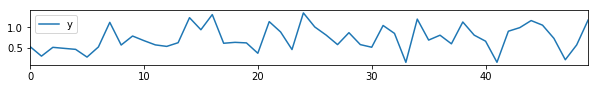

In [4]:
import pandas as pd
Xr[0:50].plot(figsize=(10,3))
# Also plot the target: 1 = background, 0 = gamma
pd.DataFrame(yr[0:50]).plot(figsize=(10,1));

> **Instructions and advice (remove before submission)**
>  
> * Answer the questions in this notebook, including the code, results, and discussions. 
> * Add precise explanations when interpreting the results of your experiments. Use markdown cells for this.
> * Submit both this notebook and a PDF through Canvas. To create the PDF, see File > Export Notebook as PDFs.
> * Submit only one notebook and one PDF per team. In Jupyter Lab, you can copy-paste cells (with results) into a single notebook. 
> * Keep the PDF below 20 pages. Remove these instructions and the general advise below in the final PDF.
> * Avoid all(!) unnecessary outputs. Only output the answers to the questions. Add ';' behind lines that > generate output to suppress unnecessary output.
> * All tasks can be completed with scikit-learn. You are allowed (but not required) to use other tools as well.
> * Training models can take time. Make sure to start computations well in advance of the deadline. 
> * Read all questions first and make a plan. You may save time by solving some of them simultaneously.
> * Questions 2 and 3 depend on question 1, but not on each other. This may help to plan the work.
> * Be efficient. Don't try every model on all the data at once. Test your code on a small part of the data (even just 1%) until you are sure that there are no more bugs or other issues.
> * Observe how long it takes to train different models on a small part of your data to learn whether the models are fast enough for what you want to do.
> * You are allowed to run code elsewhere (e.g. in Python scripts) and store the results on file. If so, copy the code in this notebook and load/visualize/discuss the results here as well.
> * On [Google Colab](https://colab.research.google.com/) you can run the notebook in the cloud.

### Team details {-}
Add the names of all team members and a short description of each member's contributions.   
TEAM MEMBER 1 = ...   
TEAM MEMBER 2 = ...  
TEAM MEMBER 3 = ...   
TEAM MEMBER 4 = ...  
TEAM MEMBER 5 = ...   

### Model-based optimization
We can use machine learning to predict which hyperparameter configuration are most likely to work well on a new dataset, given a few examples of evaluated configurations on that dataset. This is called model-based optimization, and the most well-known approach for this is called Bayesian Optimization, discussed in Lecture 6. In this assignment, we'll implement a significantly simplified version of this for our robot.

#### The surrogate model
Bayesian optimization trains a probabilistic model on the already evaluated configurations to predict the performance of any other possible configuration. As such, we can select the configuration with the lowest predicted error as the next configuration to evaluate. The most commonly used surrogate models are Gaussian Processes, which can elegantly update with every new evaluation. However, any probabilistic model can be used. In this assignment, we will also try Random Forests, which are more scalable and more easy to parallellize. 

While the implementation of Random Forests in scikit-learn does not return uncertainty intervals, it can be easily adapted. You are given a helper function that adapts the predict() function to return both the mean and standard deviation of the predictions of all trees in the forest.

#### The acquisition function
To avoid that Bayesian optimization gets stuck in a local optimum, we don't simply take the configuration with the highest predicted value. Instead, we use an _acquisition function_ that trades off exploration and exploration, favouring configurations that are both promising (low predicted error) and underexplored (high uncertainty). A commonly used acquisition function is _Expected Improvement_, which models the predicted performance as a Gaussian distribution with the predicted mean and standard deviation, and computes the _expected_ performance improvement over the previous best configuration $\mathbf{X^+}$:

$$EI(X) := \mathbb{E}\left[ \max\{0, f(\mathbf{X^+}) - f_{t+1}(\mathbf{X}) \} \right]$$

Computing the expected performance requires an integration over the posterior distribution, but has a [closed form solution](http://ash-aldujaili.github.io/blog/2018/02/01/ei/) which is implemented as a helper function below.

The complete procedure is illustrated with an artificial example below. The optimum of the acquisition function, and hence the next configuration to evaluate, is usually found using Thompson sampling (discussed later in the course), but in this assignment you can simply use a random search over the acquisition function instead. The best found configuration should then be evaluated and be used to train a new SVM model, use it's performance to update the surrogate model and repeat the cycle.

In [9]:
# Random Forest that also returns the standard deviation of predictions
from sklearn.ensemble import RandomForestRegressor
import numpy as np

class ProbabilisticRandomForestRegressor(RandomForestRegressor):
    """
    A Random Forest regressor that can also returns the standard deviations for all predictions
    """
    def predict(self, X, return_std=True):       
        preds = []
        for pred in self.estimators_:
            preds.append(pred.predict(X))
        if return_std:
            return np.mean(preds, axis=0), np.std(preds, axis=0)
        else:
            return np.mean(preds, axis=0)

In [10]:
# Helper function to compute expected improvement 
def EI(surrogate, X: np.ndarray, curr_best=0.0, balance=0.0, **kwargs):
    """Computes the Expected Improvement
    surrogate, The surrogate model
    X: np.ndarray(N, D), The input points where the acquisition function
        should be evaluated. N configurations with D hyperparameters
    curr_best, The current best performance
    balance, Decrease to focus more on exploration, increase to focus on exploitation (optional)
    Returns
    -------
    np.ndarray(N,1), Expected Improvement of X
    """
    if len(X.shape) == 1:
        X = X[:, np.newaxis]

    m, s = surrogate.predict(X) # mean, stdev

    z = (curr_best - m - balance) / s
    f = (curr_best - m - balance) * norm.cdf(z) + s * norm.pdf(z)

    if np.any(s == 0.0): # uncertainty should never be exactly 0.0
        f[s == 0.0] = 0.0

    return f

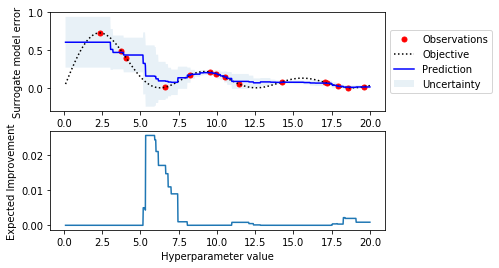

In [12]:
# Example usage (delete me)
import math
from random import randint
from scipy.stats import norm

# Articifial objective function to optimize
x_points = np.linspace(0.1,20,1000)
y_points = (1 - np.cos(x_points)) / x_points
sample = np.random.choice(1000, 15)
x_train = x_points[sample]
y_train = y_points[sample]

# Surrogate model
rf = ProbabilisticRandomForestRegressor(n_estimators=100)
rf.fit(x_train.reshape(-1, 1),y_train) # Train surrogate model
y_pred, sigma = rf.predict(x_points.reshape(-1, 1), return_std=True)

# Plot surrogate model
plt.subplot(2, 1, 1)
plt.ylabel('Surrogate model error')
plt.plot(x_train, y_train, 'r.', markersize=10, label=u'Observations');
plt.plot(x_points, y_points, 'k:', label=u'Objective');
plt.plot(x_points, y_pred, 'b-', label=u'Prediction');
plt.fill_between(x_points.ravel(),y_pred-2*sigma,y_pred+2*sigma,alpha=0.1,label='Uncertainty');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

# Plot acquisition function
plt.subplot(2, 1, 2)
plt.xlabel('Hyperparameter value');
plt.ylabel('Expected Improvement')
plt.plot(x_points, EI(rf,x_points))
plt.show()

## 1. Implementing Bayesian Optimization (60 points) {-}
* Implement Bayesian optimization using the code above and use it to optimize the hyperparameters stated below for each of the two datasets.
    - Use the hyperparameters and ranges are defined above. Make sure to sample from a log scale (`numpy.logspace`) whenever the hyperparameters should be varied on a log scale. 
    - The evaluation measure for classification should be misclassification error (1 - Accuracy), evaluated using 3-fold cross-validation
    - The evaluation measure for classification should be mean squared error, also evaluated using 3-fold cross-validation
* Initialize the surrogate model with 10 randomly sampled configurations and visualize the surrogate model.
    - Hint: Use a 2D slice of each hyperparameter (e.g. $C$=4 and $\gamma$=0.1) to show both the predicted values and the uncertainty.
    - For simplicity, you can build a separate surrogate model for each algorithm and each dataset (4 models in total) 
* Visualize the resulting acquisition function, either as 2D slices (or, more difficult, as a 3D surface)
* Visualize 3 more iterations, each time visualizing the surrogate model and acquisition function
* Run the Bayesian optimization for at least 30 iterations, report the optimal configuration and show the final surrogate model (2D slices or 3D surface).
* Interpret and explain the results. Does Bayesian optimization efficiently find good configurations? Do you notice any
differences between the different models and the different datasets. Explain the results as well as you can.

## 2. Warm-starting Bayesian Optimization (20 points) {-}

* Oh no! 6 of the sensors in the first dataset (robot navigation) suddenly broke. You need to quickly retrain the model but
there is no time for a complete re-optimization.
* Revisit question 1, but additionally keep a list of the 10 best hyperparameter configurations while you run Bayesian optimization.
* Randomly remove 6 columns from the dataset (or remove them manually as long as they are not adjacent) to simulate the broken sensors.
* Re-run the Bayesian optimization (only for the first dataset), but now start from the 10 best configurations (for each classifier) rather than 10
random ones.
* Visualize the surrogate model (as before) at the initial state, and at 3 subsequent iterations.
* Interpret and discuss the results. Did the warm-start help? Could you find a good model after a few iterations? 
Explain the benefits of this approach over starting from scratch or using a random search.

## 3. Gaussian Processes (20 points) {-}
* Replace the probabilistic Random Forest used above with a Gaussian Process.
* Repeat the Bayesian Optimization for one of the datasets, again visualizing the surrogate model and the acquisition function.
* If the surrogate models do not look right, do manual tuning
- Hint: Try `y_normalize`, regularizing the `alpha` hyperparameter, or trying a different kernel.
* Interpret and discuss the results. In which ways are the Gaussian Processes better or worse? Consider both accuracy, speed of finding a good configuration, and runtime. Interpret and explain the results as well as you can.